In [ ]:
!pip install pillow
!pip install split-folders
!pip install wandb -qqq
import splitfolders
import tensorflow as tf
import matplotlib.pyplot as plt
import wandb
from wandb.keras import WandbCallback

import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import SGD

     |████████████████████████████████| 2.1MB 11.4MB/s 
     |████████████████████████████████| 102kB 9.7MB/s 
     |████████████████████████████████| 133kB 41.5MB/s 
     |████████████████████████████████| 163kB 48.3MB/s 
     |████████████████████████████████| 71kB 7.9MB/s 


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue May  4 07:44:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#Parameters
batch_size = 160
size=(224, 224)
num_classes = 15
input_tensor = (224, 224, 3)
dropout_rate=0.2
epochs=25
lr=1e-2
TL=False
split=(0.8, 0.1, 0.1)
data_dir='/content/output/'

In [ ]:
wandb.login()
run = wandb.init(project='Deep Learning Assignment',
                 config={  
                     "learning_rate": lr,
                     "epochs": epochs,
                     "batch_size": batch_size,
                     "loss_function": "categorical_crossentropy",
                     "architecture": "ResNet-50V2",
                     "dataset": "Plant Village",
                     "optimizer":"SGD",
                     "Split": split,
                     "Transfer Learning": TL,
                     "Data Aug": True
                 })

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: flashrender (use `wandb login --relogin` to force relogin)


In [ ]:
!wget http://drive.genos-drive.workers.dev/plantvillage.zip
!unzip -qq plantvillage.zip 
splitfolders.ratio('PlantVillage', output="output", ratio=split)

--2021-05-04 07:44:27--  http://drive.genos-drive.workers.dev/plantvillage.zip
Resolving drive.genos-drive.workers.dev (drive.genos-drive.workers.dev)... 104.21.234.167, 104.21.234.166, 2606:4700:3038::6815:eaa7, ...
Connecting to drive.genos-drive.workers.dev (drive.genos-drive.workers.dev)|104.21.234.167|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 689512690 (658M) [application/zip]
Saving to: ‘plantvillage.zip’

plantvillage.zip    100%[===================>] 657.57M  74.7MB/s    in 12s     

2021-05-04 07:44:41 (53.9 MB/s) - ‘plantvillage.zip’ saved [689512690/689512690]



Copying files: 20639 files [00:04, 5108.35 files/s]


In [ ]:
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255.)
    ]
)
def load_dataset(dir, train):
  dataset = keras.preprocessing.image_dataset_from_directory(
        dir,  
        image_size=size, 
        batch_size=batch_size,
        labels="inferred",
        seed=1337,
        label_mode="categorical",
        color_mode="rgb",
        shuffle=True)
  dataset=dataset.map(lambda x, y: (data_augmentation(x, training=train), y))
  return dataset.prefetch(buffer_size=batch_size)


In [ ]:
train_generator = load_dataset(data_dir+'train', True)
validation_generator = load_dataset(data_dir+'val', False)
test_generator = load_dataset(data_dir+'test', False)

Found 16504 files belonging to 15 classes.
Found 2058 files belonging to 15 classes.
Found 2076 files belonging to 15 classes.


In [ ]:
img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [ ]:
inputs = tf.keras.layers.Input(shape=input_tensor)
x = img_augmentation(inputs)

base_model = tf.keras.applications.ResNet50V2(input_tensor=x,include_top=False,weights=None)
x = base_model.output
x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
predictions = keras.layers.Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)


model.compile(optimizer=SGD(lr=lr, momentum=0.9), loss='categorical_crossentropy',metrics=[tf.keras.metrics.CategoricalAccuracy()])

94674944/94668760 [==============================] - 3s 0us/step


In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5), 
    tf.keras.callbacks.ModelCheckpoint(filepath='modelcheckpoint/model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=0.0001),
    WandbCallback()
]

In [ ]:
history=model.fit(train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    callbacks=my_callbacks)

Epoch 1/25
104/104 [==============================] - 86s 784ms/step - loss: 0.5049 - categorical_accuracy: 0.8368 - val_loss: 1.2129 - val_categorical_accuracy: 0.6944
Epoch 2/25
104/104 [==============================] - 80s 747ms/step - loss: 0.1131 - categorical_accuracy: 0.9613 - val_loss: 0.4759 - val_categorical_accuracy: 0.8416
Epoch 3/25
104/104 [==============================] - 80s 744ms/step - loss: 0.0661 - categorical_accuracy: 0.9779 - val_loss: 0.2419 - val_categorical_accuracy: 0.9198
Epoch 4/25
104/104 [==============================] - 80s 745ms/step - loss: 0.0339 - categorical_accuracy: 0.9885 - val_loss: 0.5494 - val_categorical_accuracy: 0.8669
Epoch 5/25
104/104 [==============================] - 80s 745ms/step - loss: 0.0334 - categorical_accuracy: 0.9898 - val_loss: 0.3346 - val_categorical_accuracy: 0.9028
Epoch 6/25
104/104 [==============================] - 80s 745ms/step - loss: 0.0246 - categorical_accuracy: 0.9916 - val_loss: 0.0822 - val_categorical_acc

In [ ]:
print("Evaluate on test data")
results = model.evaluate(test_generator)
print("test loss, test acc:", results)

Evaluate on test data
13/13 [==============================] - 8s 339ms/step - loss: 0.0260 - categorical_accuracy: 0.9923
test loss, test acc: [0.025997765362262726, 0.9922928810119629]


In [ ]:
modeltest = keras.models.load_model('/content/modelcheckpoint/model.22-0.01.h5')
wandb.save("/content/modelcheckpoint/model.22-0.01.h5")
results = modeltest.evaluate(test_generator)
print("test loss, test acc:", results)

wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


13/13 [==============================] - 7s 256ms/step - loss: 0.0256 - categorical_accuracy: 0.9904
test loss, test acc: [0.02556627057492733, 0.9903661012649536]


In [ ]:
!zip -r my_model.zip modelcheckpoint/ wandb/ logs/
!cp my_model.zip "/content/drive/Shareddrives/Untitled shared drive/my_model_EfficientNetB0.zip"

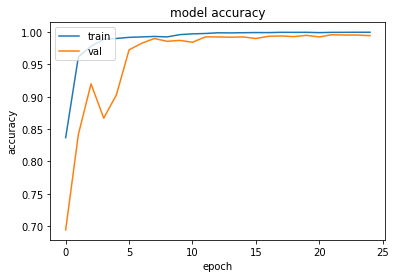

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

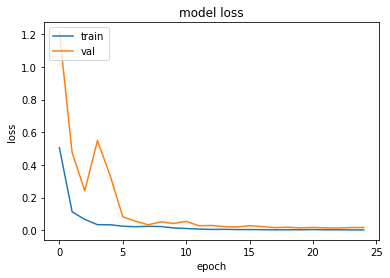

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()